# MNIST digit classification with a fully connected network (fcNN)


**Goal:** In this notebook you will see how to use a fully connected networks (fcNN) in a classification task for images.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. 

**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the MNIST data 
* transform the labels into the one hot encoding
* visualize samples of the data
* flatten the 2D images into a 1D vector
* use keras to train a fcNN and look at the perfomance on new unseen test data
* use different activation functions and more hidden layers

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_02a.ipynb)



#### Install correct TF version (colab only)

#### Imports

In the next two cells, we load all the required libraries and functions. 

In [2]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [3]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.12.0  running in colab?:  False


In [4]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers

#### Loading and preparing the MNIST data and transfering the labels into the one hot encoding

Here we load the MNIST dataset form keras. The 8-bit greyscale images have values form 0 to 255, we divide all values with 255 so that the values are in a range between 0 and 1. In additon we transform the true labels, which are the numbers from 0 to 9 (the digit on the image) into the one hot encoding. We do this to make use of linear algebra in the calculation of the crossentropy loss.  
  
The one hot encoding transforms the labels into a vector with the same length as we have labels (in our case 10). The resulting vector in the one hot encodig is zero everywhere except for the position of the true label, there it is 1. Let's look at some examples to make it more clear:  

0 becomes [1,0,0,0,0,0,0,0,0,0]  
1 becomes [0,1,0,0,0,0,0,0,0,0]  
2 becomes [0,0,1,0,0,0,0,0,0,0]  
...  
9 becomes [0,0,0,0,0,0,0,0,0,1]  

#### Listing 2.3 Loading the MNIST data


In [5]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

11490434/11490434 [==============================] - 3s 0us/step
(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(50000, 10)
(10000, 10)
(10000, 10)


Let's visualize the first 4 mnist images. It is very easy to recognise the true label of the digits.

C:\Users\lsl\AppData\Local\Temp\ipykernel_19004\2924388069.py:6: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))


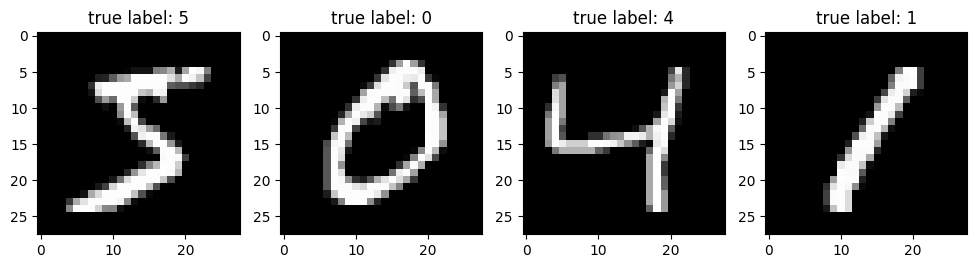

In [6]:
# visualize the 4 first mnist images before shuffling the pixels
plt.figure(figsize=(12,12))
for i in range(0,4):
    plt.subplot(1,4,(i+1))
    plt.imshow((X_train[i,:,:,0]),cmap="gray")
    plt.title('true label: '+np.str(np.argmax(Y_train,axis=1)[i]))
    #plt.axis('off')

## fcNN as classification model for MNIST data
Now we want to train a fcNN to classify the MNIST data.
* we use a fcNN with 2 hidden layers and use the sigmoid activation function
* train it on train data and check the performance on the test data


#### Flatten the the images into vectors

Because we will use fcNN our input cannot be matrices or tensors. We need to flatten our inuput into a 1d vector. We do this in the next cell with reshap and look at the resulting shape of the flattened data.

In [7]:
# prepare data for fcNN - we need a vector as input

X_train_flat = X_train.reshape([X_train.shape[0], 784])
X_val_flat = X_val.reshape([X_val.shape[0], 784])
X_test_flat = X_test.reshape([X_test.shape[0], 784])

# check the shape
print(X_train_flat.shape)
print(Y_train.shape)
print(X_val_flat.shape)
print(Y_val.shape)

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)


### Train the fcNN 

Here we define the nework, we use two hidden layers with 100 and 50 nodes. In the output we predict the probability for the 10 digits with the softmax actication function, in the hidden layers we use the sigmoid activation function and our loss is the categroical crossentropy loss.

#### Listing 2.4 Definition of an fcNN  for the MNIST data


In [8]:
# define fcNN with 2 hidden layers
model = Sequential()

model.add(Dense(100, batch_input_shape=(None, 784)))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 84,060
Trainable params: 84,060
Non-traina

In [10]:
# train the model
history=model.fit(X_train_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_flat, Y_val)
                 )

Epoch 1/10


391/391 - 1s - loss: 1.0026 - accuracy: 0.7815 - val_loss: 0.4006 - val_accuracy: 0.9059 - 1s/epoch - 3ms/step
Epoch 2/10
391/391 - 1s - loss: 0.3365 - accuracy: 0.9121 - val_loss: 0.2536 - val_accuracy: 0.9321 - 550ms/epoch - 1ms/step
Epoch 3/10
391/391 - 1s - loss: 0.2443 - accuracy: 0.9315 - val_loss: 0.2040 - val_accuracy: 0.9421 - 559ms/epoch - 1ms/step
Epoch 4/10
391/391 - 1s - loss: 0.1981 - accuracy: 0.9431 - val_loss: 0.1727 - val_accuracy: 0.9519 - 529ms/epoch - 1ms/step
Epoch 5/10
391/391 - 1s - loss: 0.1662 - accuracy: 0.9522 - val_loss: 0.1529 - val_accuracy: 0.9582 - 518ms/epoch - 1ms/step
Epoch 6/10
391/391 - 1s - loss: 0.1419 - accuracy: 0.9591 - val_loss: 0.1375 - val_accuracy: 0.9619 - 577ms/epoch - 1ms/step
Epoch 7/10
391/391 - 1s - loss: 0.1229 - accuracy: 0.9653 - val_loss: 0.1247 - val_accuracy: 0.9644 - 620ms/epoch - 2ms/step
Epoch 8/10
391/391 - 1s - loss: 0.1069 - accuracy: 0.9698 - val_loss: 0.1153 - val_accuracy: 0.9681 - 537ms/epoch - 1ms/step
Epoch 9/10
391

In the next cell we plot the accuray and loss of the train and validation vs the number of train eprochs to see how the development

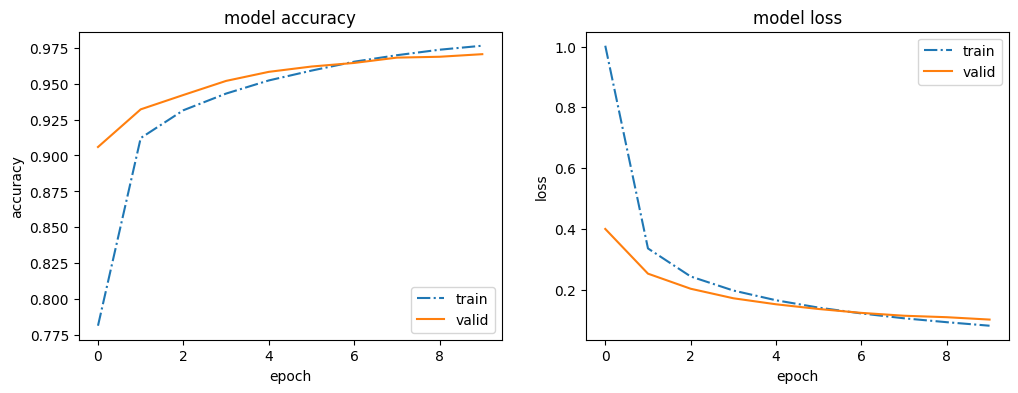

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

#### Prediction on the original test set after training on original data

Now, let's use the fcNN that was trained on the flattened MNIST data to predict new unseen data (our testdata).
We determine the confusion matrix and the accuracy on the testdata to evaluate the classification performance.


In [12]:
pred=model.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

313/313 [==============================] - 0s 668us/step
[[ 966    0    0    2    0    3    6    1    1    1]
 [   0 1122    2    1    0    1    4    1    4    0]
 [   6    2 1005    1    2    1    4    5    6    0]
 [   1    0    7  981    0    4    0    9    6    2]
 [   1    0    5    0  951    0    7    2    2   14]
 [   3    1    1   13    2  850    9    2    8    3]
 [   6    3    1    1    3    5  934    0    5    0]
 [   1    4   12    8    0    1    0  990    1   11]
 [   6    1    4    9    3    5    5    5  934    2]
 [   5    5    1    8   16    4    1    8    3  958]]
Acc_fc_orig_flat =  0.9691



####  *We get an accuray of around 97% on the test data!*

#### Play the deep learning game and stack more layers and change the activation function from sigmoid to relu
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*Exercise: Try to improve the fcNN by adding more hidden layers and/or changing the activation function from "sigmoid" to "relu". What do you observe? can you improve the performace on the testset?*



create a new model

In [13]:
model_fcnn = Sequential()

model_fcnn.add(Dense(100, batch_input_shape=(None, 784)))
model_fcnn.add(Activation('relu'))
model_fcnn.add(Dense(80))
model_fcnn.add(Activation('relu'))
model_fcnn.add(Dense(50))
model_fcnn.add(Activation('relu'))
model_fcnn.add(Dense(30))
model_fcnn.add(Activation('relu'))
model_fcnn.add(Dense(10))
model_fcnn.add(Activation('softmax'))

# compile model and intitialize weights
model_fcnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_fcnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 activation_3 (Activation)   (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 80)                8080      
                                                                 
 activation_4 (Activation)   (None, 80)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                4050      
                                                                 
 activation_5 (Activation)   (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)               

train the model

In [14]:
history_fcnn=model_fcnn.fit(X_train_flat, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val_flat, Y_val)
                 )

Epoch 1/10
391/391 - 1s - loss: 0.4053 - accuracy: 0.8809 - val_loss: 0.1722 - val_accuracy: 0.9501 - 1s/epoch - 3ms/step
Epoch 2/10
391/391 - 1s - loss: 0.1452 - accuracy: 0.9561 - val_loss: 0.1240 - val_accuracy: 0.9657 - 579ms/epoch - 1ms/step
Epoch 3/10
391/391 - 1s - loss: 0.1015 - accuracy: 0.9697 - val_loss: 0.0979 - val_accuracy: 0.9702 - 549ms/epoch - 1ms/step
Epoch 4/10
391/391 - 1s - loss: 0.0809 - accuracy: 0.9750 - val_loss: 0.1271 - val_accuracy: 0.9609 - 571ms/epoch - 1ms/step
Epoch 5/10
391/391 - 1s - loss: 0.0663 - accuracy: 0.9800 - val_loss: 0.0950 - val_accuracy: 0.9727 - 582ms/epoch - 1ms/step
Epoch 6/10
391/391 - 1s - loss: 0.0514 - accuracy: 0.9840 - val_loss: 0.1134 - val_accuracy: 0.9677 - 589ms/epoch - 2ms/step
Epoch 7/10
391/391 - 1s - loss: 0.0449 - accuracy: 0.9854 - val_loss: 0.0919 - val_accuracy: 0.9746 - 581ms/epoch - 1ms/step
Epoch 8/10
391/391 - 1s - loss: 0.0398 - accuracy: 0.9874 - val_loss: 0.0963 - val_accuracy: 0.9729 - 547ms/epoch - 1ms/step
Epo

plot the graphs:

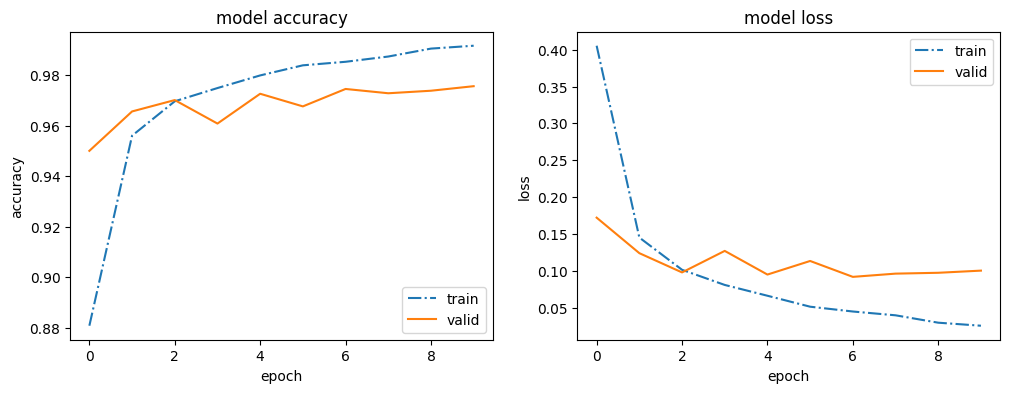

In [15]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_fcnn.history['accuracy'],linestyle='-.')
plt.plot(history_fcnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history_fcnn.history['loss'],linestyle='-.')
plt.plot(history_fcnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

test the improved model

In [16]:
pred_fcnn=model_fcnn.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred_fcnn,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred_fcnn,axis=1))/len(pred_fcnn)
print("Acc_fc_orig_flat = " , acc_fc_orig)

313/313 [==============================] - 0s 771us/step
[[ 963    0    1    1    1    1    5    1    5    2]
 [   2 1124    5    0    0    1    0    0    3    0]
 [   3    1 1014    0    1    0    2    4    6    1]
 [   0    0   11  977    0    7    0    4    5    6]
 [   2    0    4    0  949    1    2    0    0   24]
 [   3    0    0    9    3  866    1    0    7    3]
 [   5    2    1    0    8   10  923    0    9    0]
 [   1    2   11    1    1    0    0  997    3   12]
 [   5    1    1    3    2    3    1    4  952    2]
 [   1    2    2    0    5    4    0    4    3  988]]
Acc_fc_orig_flat =  0.9753


### Lets train a Convolutional Neural Network (CNN)!

* Use the previous code to complete this part of the task
* Change our fcNN to a CNN, it should look something like this:

![Hello World]( 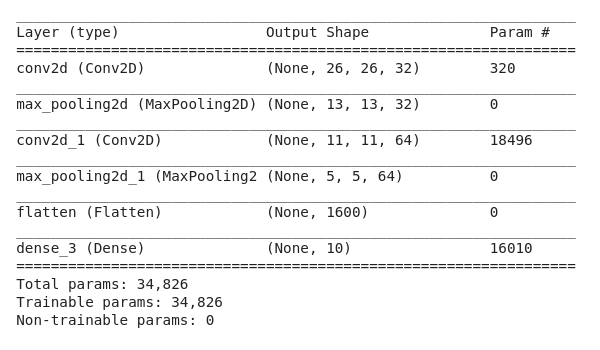)


* We don't need to flatten our input this time!
* Train the CNN and use the same parameters as before (10 epochs, batchsize 128, etc.)
* Visualize the loss/accuracy like before, but include the loss of our fcNN so we can see a difference
* Use the testset to create a confusion matrix and compare it with our fcNN




load the training and test data:

In [17]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# separate x_train in X_train and X_val, same for y_train
X_train=x_train[0:50000] / 255 #divide by 255 so that they are in range 0 to 1
Y_train=keras.utils.to_categorical(y_train[0:50000],10) # one-hot encoding

X_val=x_train[50000:60000] / 255
Y_val=keras.utils.to_categorical(y_train[50000:60000],10)

X_test=x_test / 255
Y_test=keras.utils.to_categorical(y_test,10)

del x_train, y_train, x_test, y_test

X_train=np.reshape(X_train, (X_train.shape[0],28,28,1))
X_val=np.reshape(X_val, (X_val.shape[0],28,28,1))
X_test=np.reshape(X_test, (X_test.shape[0],28,28,1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
(50000, 10)
(10000, 10)
(10000, 10)


create the cnn model and train it:

In [18]:
model = Sequential()

model.add(Convolution2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history_cnn=model.fit(X_train, Y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2, 
                  validation_data=(X_val, Y_val)
                 )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 10)               

Epoch 1/10
391/391 - 9s - loss: 0.2865 - accuracy: 0.9233 - val_loss: 0.0811 - val_accuracy: 0.9766 - 9s/epoch - 24ms/step
Epoch 2/10
391/391 - 9s - loss: 0.0743 - accuracy: 0.9770 - val_loss: 0.0593 - val_accuracy: 0.9825 - 9s/epoch - 24ms/step
Epoch 3/10
391/391 - 9s - loss: 0.0542 - accuracy: 0.9834 - val_loss: 0.0567 - val_accuracy: 0.9845 - 9s/epoch - 23ms/step
Epoch 4/10
391/391 - 9s - loss: 0.0433 - accuracy: 0.9870 - val_loss: 0.0530 - val_accuracy: 0.9845 - 9s/epoch - 23ms/step
Epoch 5/10
391/391 - 9s - loss: 0.0373 - accuracy: 0.9888 - val_loss: 0.0433 - val_accuracy: 0.9874 - 9s/epoch - 23ms/step
Epoch 6/10
391/391 - 9s - loss: 0.0322 - accuracy: 0.9899 - val_loss: 0.0397 - val_accuracy: 0.9880 - 9s/epoch - 24ms/step
Epoch 7/10
391/391 - 9s - loss: 0.0270 - accuracy: 0.9915 - val_loss: 0.0461 - val_accuracy: 0.9873 - 9s/epoch - 23ms/step
Epoch 8/10
391/391 - 9s - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0400 - val_accuracy: 0.9885 - 9s/epoch - 23ms/step
Epoch 9/10
391/3

plot loss accuracy and compare it to fcnn:

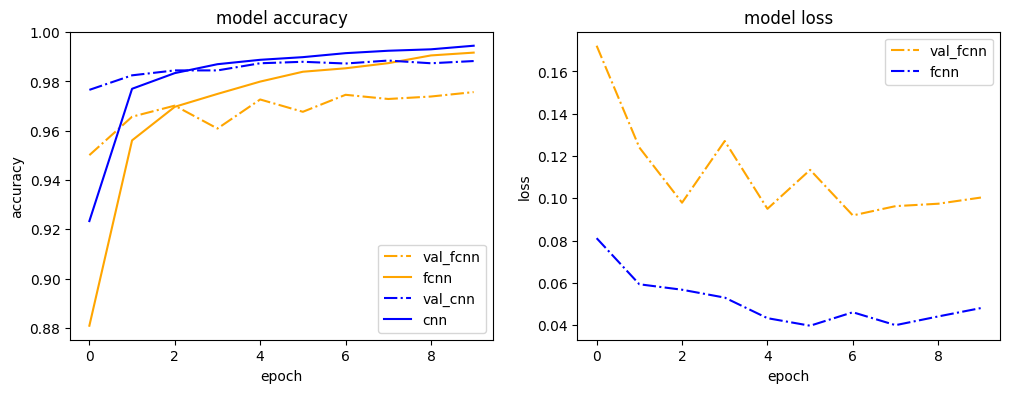

In [19]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history_fcnn.history['val_accuracy'],linestyle='-.', color='orange')
plt.plot(history_fcnn.history['accuracy'], color='orange')
plt.plot(history_cnn.history['val_accuracy'], linestyle='-.', color='blue')
plt.plot(history_cnn.history['accuracy'], color='blue')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_fcnn', 'fcnn', 'val_cnn', 'cnn'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history_fcnn.history['val_loss'],linestyle='-.', color='orange')
plt.plot(history_cnn.history['val_loss'], linestyle='-.', color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_fcnn', 'fcnn', 'val_cnn', 'cnn'], loc='upper right')

create confusion matrix and compare it:

In [20]:
print("fcnn")

pred_fcnn=model_fcnn.predict(X_test_flat)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred_fcnn,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred_fcnn,axis=1))/len(pred_fcnn)
print("Acc_fc_orig_flat = " , acc_fc_orig)


print("cnn")

pred_cnn=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred_cnn,axis=1)))
acc_fc_orig = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred_cnn,axis=1))/len(pred_cnn)
print("Acc_fc_orig_flat = " , acc_fc_orig)

fcnn
  1/313 [..............................] - ETA: 6s

313/313 [==============================] - 0s 683us/step
[[ 963    0    1    1    1    1    5    1    5    2]
 [   2 1124    5    0    0    1    0    0    3    0]
 [   3    1 1014    0    1    0    2    4    6    1]
 [   0    0   11  977    0    7    0    4    5    6]
 [   2    0    4    0  949    1    2    0    0   24]
 [   3    0    0    9    3  866    1    0    7    3]
 [   5    2    1    0    8   10  923    0    9    0]
 [   1    2   11    1    1    0    0  997    3   12]
 [   5    1    1    3    2    3    1    4  952    2]
 [   1    2    2    0    5    4    0    4    3  988]]
Acc_fc_orig_flat =  0.9753
cnn
313/313 [==============================] - 1s 3ms/step
[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1127    2    1    2    0    2    1    0    0]
 [   2    2 1014    1    3    0    4    3    3    0]
 [   0    0    0 1009    0    0    0    1    0    0]
 [   0    0    0    0  981    0    1    0    0    0]
 [   2    0    0   11    0  872    5    0    1    1]
 [   3  

Save the model

In [23]:
model.save("cnn_mnist.h5")